In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-wobasoo6 because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
benchmark_dfs = []
for run in range(5):
    df = pd.read_csv(f"run_{run}/benchmark.csv")
    df['run'] = run
    benchmark_dfs.append(df)

In [6]:
df = pd.concat(benchmark_dfs, ignore_index=True)
df = df.fillna('op')
df

,cores,operation,part,elapsedRealTime,run
0,1,download,raw,373.42,0
1,1,download,mzid,12.72,0
2,1,download,mzml,134.61,0
3,1,convertraw,op,338.39,0
4,1,extract,op,11.44,0
...,...,...,...,...,...
135,4,download,mzml,118.12,4
136,4,convertraw,op,146.20,4
137,4,extract,op,10.30,4
138,4,mz2parquet,op,1929.81,4


Int64Index([1, 2, 4, 8], dtype='int64', name='cores')

In [44]:
cmp_results = df.groupby(['run', 'operation', 'cores'])\
.sum()\
.reset_index()\
.drop(columns=['run'])\
.groupby('operation')\
.apply(lambda d: d.set_index('cores').elapsedRealTime)\
.T\
.groupby('cores')\
.apply(lambda d: d.describe())\
.T
cmp_results

cores           1                                                            \
            count      mean         std      min      25%      50%      75%   
operation                                                                     
convertraw    5.0   340.438    4.940083   335.82   338.32   338.39   341.02   
download      5.0   573.352  108.988736   459.16   515.64   520.75   645.76   
extract       5.0    15.438    2.332953    11.44    15.63    16.21    16.43   
mgf2parquet   5.0    91.922    1.840033    89.83    90.60    91.62    93.32   
mz2parquet    5.0  3780.602  163.695707  3655.95  3672.18  3755.63  3758.01   

cores                    2            ...        4              8            \
                 max count      mean  ...      75%      max count      mean   
operation                             ...                                     
convertraw    348.64   5.0   196.416  ...   144.67   146.20   5.0   104.222   
download      725.45   5.0   564.040  ...   587.23   804.73   5.0   542.848   
extract        17.48   5.0     9.296  ...    10.74    11.30   5.0     9.136   
mgf2parquet    94.24   5.0    52.684  ...    33.61    34.13   5.0    28.736   
mz2parquet   4061.24   5.0  2363.460  ...  1791.11  1929.81   5.0  1587.182   

cores                                                                 
                    std      min      25%      50%      75%      max  
operation                                                             
convertraw     1.246603   103.44   103.55   103.70   104.00   106.42  
download     137.097380   441.35   450.10   459.68   607.79   755.32  
extract        0.422942     8.90     8.93     8.97     8.99     9.89  
mgf2parquet    0.774648    27.76    28.14    28.94    29.18    29.66  
mz2parquet    41.840329  1541.86  1544.34  1600.41  1616.58  1632.72  

[5 rows x 32 columns]

In [52]:
def plot_benchmark(
    cmp_results: pd.DataFrame,
    title: str = 'test',
    bars = None, 
    labels = None,
    bar_labels = None,
    colours = ['tab:blue', 'tab:green', 'tab:orange', 'tab:red'],
    bar_width = 0.2,
    opacity = 1.0,
    error_config = {'ecolor': 'black'},
    ax = None,
):
    if labels is None:
        labels = cmp_results.index
        
    if bars is None:
        bars = cmp_results.columns
    
    if bar_labels is None:
        bar_labels = bars
        
    if bar_width * len(bars) > 1.0:
        bar_width = 0.8 / len(bars)
    
    index = np.arange(len(cmp_results))
    if ax is None:
        fig, ax = plt.subplots()
        given_ax = False
    else:
        given_ax = True

    for i, bar in enumerate(bars):
        ax.bar(
            index + i*bar_width,
            cmp_results[bar]['mean'],
            bar_width,
            alpha=opacity,
            color=colours[i],
            yerr=cmp_results[bar]['std'],
            error_kw=error_config,
            label=bar_labels[i]
        )

    ax.set_xlabel('MMProteo Operation')
    ax.set_ylabel('Runtime in Seconds')
    ax.set_yscale('log')
    #ax.ticklabel_format(style='plain')
    ax.set_title(title)
    ax.set_xticks(index + bar_width)
    ax.set_xticklabels(labels)
    ax.legend()

    if not given_ax:
        fig.tight_layout()
        plt.show()

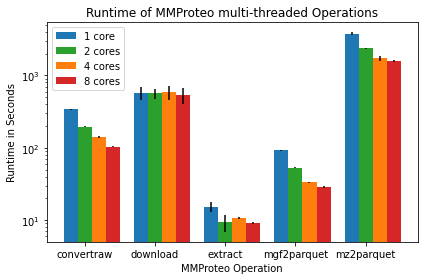

In [53]:
cores = cmp_results.columns.levels[0]

fig, ax = plt.subplots()

plot_benchmark(
    cmp_results,
    bars=cores,
    bar_labels = [f"{core} core{'s' if int(core) > 1 else ''}" for core in cores],
    title="Runtime of MMProteo multi-threaded Operations",
    ax=ax,
)

fig.tight_layout()

plt.rcParams['svg.fonttype'] = 'none'
plt.savefig('mmproteo_multithreading_benchmark.pdf')
plt.savefig('mmproteo_multithreading_benchmark.png')
plt.savefig('mmproteo_multithreading_benchmark.svg')

plt.show()